In [64]:
import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Dropout, TimeDistributed, LayerNormalization, GlobalAveragePooling1D, Conv1D, Masking, Layer, Embedding, Concatenate
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

import keras_tuner as kt

import xgboost as xgb

In [65]:
pca_flag = False

In [66]:
df = pd.read_csv(
    '/kaggle/input/last_ball_of_over_player_stats.csv',
    dtype=float,
    low_memory=True
)

In [67]:
every_n_overs = 6

In [68]:
allowed_overs = [i for i in range(1, 51, every_n_overs)]
df = df[df['over'].isin(allowed_overs)]

In [69]:
df['over'].unique()

array([ 1.,  7., 13., 19., 25., 31., 37., 43., 49.])

In [70]:
df = df.loc[:, ~df.columns.str.contains('_vs_')]
df = df.loc[:, ~df.columns.str.contains('_is_')]
df = df.loc[:, ~df.columns.str.contains('_sr')]
df = df.loc[:, ~df.columns.str.contains('_economy')]

batter_cols = [
    col for col in df.columns if (
        (
            ('bat_team_player_' in col and '_avg' not in col and '_is_left' not in col) or
            ('bowl_team_top_bowler_' in col and '_bowling_avg' not in col and '_is_spin' not in col)
        )
    )
]


df = df.drop(columns=batter_cols)

df['recent_wickets'] = (
    df['recent_fast_wickets'] + df['recent_legspin_wickets'] +
    df['recent_medium_wickets'] + df['recent_offspin_wickets'] +
    df['recent_slow_wickets'] + df['recent_unknown_wickets']
)

# df['sum_wickets'] = (
#     df['sum_fast_wickets'] + df['sum_legspin_wickets'] +
#     df['sum_medium_wickets'] + df['sum_offspin_wickets'] +
#     df['sum_slow_wickets'] + df['sum_unknown_wickets']
# )

# df['recent_runs'] = (
#     df['recent_runs_left_hand'] + df['recent_runs_right_hand']
# )

# df['sum_runs'] = (
#     df['sum_runs_left_hand'] + df['sum_runs_right_hand']
# )

df = df.drop(columns=[
    'fast_wickets', 'legspin_wickets', 'medium_wickets', 'offspin_wickets', 
    'slow_wickets', 'unknown_wickets', 'runs_left_hand', 'runs_right_hand', 
    'sum_fast_wickets', 'recent_fast_wickets', 'sum_legspin_wickets', 
    'recent_legspin_wickets', 'sum_medium_wickets', 'recent_medium_wickets', 
    'sum_offspin_wickets', 'recent_offspin_wickets', 'sum_slow_wickets', 
    'recent_slow_wickets', 'sum_unknown_wickets', 'recent_unknown_wickets', 
    'sum_runs_left_hand', 'recent_runs_left_hand', 'sum_runs_right_hand', 
    'recent_runs_right_hand'
])

df = df.drop(columns=['win_rate_last_5','win_rate_last_5_bowl', 'avg_wkts_last_5', 'runs_extras','temperature_2m', 'relative_humidity_2m', 'cloud_cover','wind_speed_10m', 'dew_point_2m'])
df = df.drop(columns=['over_total_score', 'next_over_total_score'])

In [71]:
X = df.drop(columns=['innings_total_score', 'ball'])
y = df['innings_total_score']

X = X.apply(pd.to_numeric, errors='coerce')

In [72]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

X_test = X[X['year'] >= 2025].copy()
X_train_val = X[X['year'] < 2025].copy()

grouping_cols = ['match_id', 'innings', 'over', 'year']

X_train_val_features = X_train_val.drop(columns=grouping_cols)
X_test_features = X_test.drop(columns=grouping_cols)

scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val_features)
X_test_scaled = scaler.transform(X_test_features)

normalizer = Normalizer()
X_train_val_scaled = normalizer.fit_transform(X_train_val_scaled)
X_test_scaled = normalizer.transform(X_test_scaled)

if pca_flag:
    pca = PCA(n_components=0.9)
    X_train_val_pca = pca.fit_transform(X_train_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    X_train_val_pca_df = pd.DataFrame(X_train_val_pca, index=X_train_val.index)
    X_test_pca_df = pd.DataFrame(X_test_pca, index=X_test.index)

else:
    X_train_val_pca_df = pd.DataFrame(X_train_val_scaled, index=X_train_val.index)
    X_test_pca_df = pd.DataFrame(X_test_scaled, index=X_test.index)

X_train_val_processed = pd.concat([X_train_val[grouping_cols], X_train_val_pca_df], axis=1)
X_test_processed = pd.concat([X_test[grouping_cols], X_test_pca_df], axis=1)

X = pd.concat([X_train_val_processed, X_test_processed])

In [73]:
X_test = X[X['year'] >= 2025].copy()
X_train = X[(X['year'] < 2025)].copy()
train_match_ids = X_train['match_id'].unique().tolist()
test_match_ids = X_test['match_id'].unique().tolist()

y_train = y[(X['year'] < 2025)].copy()
y_test = y[X['year'] >= 2025].copy()

In [74]:
train_ids, val_ids = train_test_split(X_train['match_id'].unique(), test_size=0.10, random_state=42)

X_train_seq = X_train[X_train['match_id'].isin(train_ids)]
X_val_seq = X_train[X_train['match_id'].isin(val_ids)]

y_train_seq = y_train[y_train.index.isin(X_train_seq.index)]
y_val_seq = y_train[y_train.index.isin(X_val_seq.index)]

print(X_train_seq.shape, X_val_seq.shape)
print(y_train_seq.shape, y_val_seq.shape)

(17516, 29) (1948, 29)
(17516,) (1948,)


In [75]:
X_train_val_features.columns

Index(['Unnamed: 0', 'runs_batter', 'runs_total', 'batter_total_runs',
       'batter_balls_faced', 'bowler_total_runs', 'bowler_balls_bowled',
       'team_total_runs', 'wickets_taken', 'rr', 'remaining_balls', 'rrr',
       'avg_runs_last_5', 'bat_team_player_1_avg', 'bat_team_player_2_avg',
       'bat_team_player_3_avg', 'bat_team_player_4_avg',
       'bat_team_player_5_avg', 'bat_team_player_6_avg',
       'bowl_team_top_bowler_1_bowling_avg',
       'bowl_team_top_bowler_2_bowling_avg',
       'bowl_team_top_bowler_3_bowling_avg',
       'bowl_team_top_bowler_4_bowling_avg',
       'bowl_team_top_bowler_5_bowling_avg', 'recent_wickets'],
      dtype='object')

In [76]:
def convert_to_sequences(X_df, y_series, key_cols=('match_id', 'innings'),
                        time_col='over', max_len=len(allowed_overs), feature_cols=None,
                        exclude_cols=['match_id', 'year']):
    if feature_cols is None:
        exclude = set(key_cols) | {time_col} | set(exclude_cols)
        feature_cols = [c for c in X_df.columns if c not in exclude]

    seqs, targets = [], []

    for key_vals, grp in X_df.groupby(list(key_cols)):
        grp = grp.sort_values(time_col)
        feats = grp[feature_cols].to_numpy(dtype=np.float32)

        if feats.shape[0] >= max_len:
            padded = feats[:max_len]
            target_padded = y_series.loc[grp.index].values[:max_len]
        else:
            pad = np.full((max_len - feats.shape[0], feats.shape[1]), -1, dtype=np.float32)
            padded = np.vstack([feats, pad])

            target_pad = np.full(max_len - feats.shape[0], -1, dtype=np.float32)
            target_padded = np.concatenate([y_series.loc[grp.index].values, target_pad])

        seqs.append(padded)
        targets.append(target_padded)

    X_seq = np.stack(seqs, axis=0)
    y_seq = np.stack(targets, axis=0)
    return X_seq, y_seq

In [77]:
X_train_non_sequence = X_train_seq.copy()
y_train_non_sequence = y_train_seq.copy()
X_val_non_sequence = X_val_seq.copy()
y_val_non_sequence = y_val_seq.copy()
X_test_non_sequence = X_test.copy()
y_test_non_sequence = y_test.copy()

X_train_seq, y_train_seq = convert_to_sequences(X_train_seq, y_train_seq)
X_val_seq, y_val_seq = convert_to_sequences(X_val_seq, y_val_seq)
X_test_seq, y_test_seq = convert_to_sequences(X_test, y_test)

print(X_train_seq.shape, y_train_seq.shape)
print(X_val_seq.shape, y_val_seq.shape)
print(X_test_seq.shape, y_test_seq.shape)

(2221, 9, 25) (2221, 9)
(246, 9, 25) (246, 9)
(44, 9, 25) (44, 9)


In [78]:
model = Sequential()
model.add(Input(shape=(len(allowed_overs), X_train_seq.shape[2])))
model.add(Masking(mask_value=-1))   

model.add(Conv1D(filters=256, kernel_size=7, activation='relu', padding='same'))
model.add(Conv1D(filters=128, kernel_size=7, activation='relu', padding='same'))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
    
model.add(LSTM(256, return_sequences=True)) 
model.add(LSTM(128, return_sequences=True, dropout=0.1))
model.add(LSTM(128, return_sequences=True, dropout=0.1))

model.add(LayerNormalization())

model.add(TimeDistributed(Dense(256, activation='relu')))
model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(TimeDistributed(Dense(32, activation='relu')))
model.add(TimeDistributed(Dense(16, activation='relu')))
model.add(TimeDistributed(Dense(1, activation='linear')))

optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_9' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [79]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-8,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [80]:
epochs = 125
batch_size = 256

In [81]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

Epoch 1/125
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 279ms/step - loss: 57378.7109 - val_loss: 55947.3438 - learning_rate: 0.0010
Epoch 2/125
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 54582.6055 - val_loss: 46520.7656 - learning_rate: 0.0010
Epoch 3/125
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 39601.1562 - val_loss: 11968.7920 - learning_rate: 0.0010
Epoch 4/125
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 12821.3184 - val_loss: 9643.2686 - learning_rate: 0.0010
Epoch 5/125
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 10791.7881 - val_loss: 10125.1338 - learning_rate: 0.0010
Epoch 6/125
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 10292.6582 - val_loss: 9882.1309 - learning_rate: 0.0010
Epoch 7/125
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9818.3564
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9910.0039 - val_loss: 9775.6729 - learning_rate: 0.0010
Epoch 8/125
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 

In [82]:
y_pred = model.predict(X_test_seq)
y_pred = y_pred.squeeze(-1)

rmse = np.sqrt(np.mean((y_test_seq - y_pred) ** 2))
print(f'RMSE: {rmse}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
RMSE: 17.79420233536858


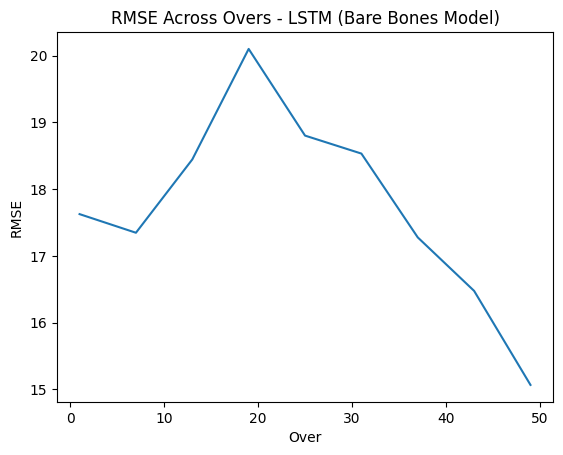

In [83]:
rmse_per_timestep = np.sqrt(np.mean((y_test_seq - y_pred) ** 2, axis=0))

plt.figure()
plt.plot(allowed_overs, rmse_per_timestep)
plt.xlabel('Over')
plt.ylabel('RMSE')
plt.title('RMSE Across Overs - LSTM (Bare Bones Model)')
plt.show()

In [84]:
# model.save_weights('13_7.weights.h5')